In [1]:
import gymnasium as gym
import numpy as np
import os
import imageio
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

from gymnasium.wrappers import *
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv

In [2]:
plt.style.use('fivethirtyeight')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 1. Environment  creation

In [3]:
[k for k in gym.envs.registry.keys() if 'Car' in k]

['CartPole-v0',
 'CartPole-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'phys2d/CartPole-v0',
 'phys2d/CartPole-v1',
 'CarRacing-v2']

In [4]:
def wrapped_env(env_name):
    env = gym.make(
        env_name,
        render_mode='rgb_array',
        continuous=False
    )
    env = MaxAndSkipEnv(env, skip=4)
    env = ResizeObservation(env, 84)
    env = GrayScaleObservation(env)
    env = FrameStack(env, 5)
    return env

env = wrapped_env('CarRacing-v2')

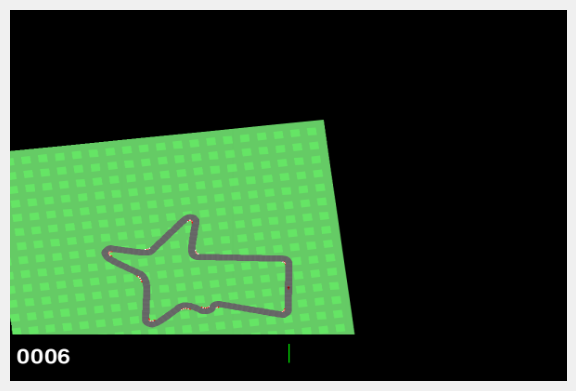

In [5]:
init_state, info = env.reset(seed=123)
img = env.render()

plt.imshow(img)
plt.axis("off")
plt.savefig('./car_init.png')
plt.show()

In [6]:
obs_shape = env.observation_space.shape
action_shape = env.action_space.shape
n_action = env.action_space.n

print(init_state.shape)
print('obs_shape:', obs_shape)
print('action_shape:', action_shape)
print('n_action:', n_action)

(5, 84, 84)
obs_shape: (5, 84, 84)
action_shape: ()
n_action: 5


# 2. Classes and functions

In [7]:
# one model Actor and Critic
class ActorCritic(nn.Module):
    
    def __init__(self, num_inputs, num_actions):
        super(ActorCritic, self).__init__()
        # Common layers
        self.conv1 = nn.Conv2d(
            num_inputs, 32, kernel_size=7, stride=2, padding=1
        )
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(128*5*5, 512)
        self.policy_fc = nn.Linear(512, num_actions)
        self.value_fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # flatten
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        logits = self.policy_fc(x) # Actor
        state_values = self.value_fc(x) # Critic
        return Categorical(logits=logits), state_values

In [8]:
class Storage:
    def __init__(self, steps_per_update):
        self.steps_per_update = steps_per_update
        self.expected_rewards = torch.zeros(self.steps_per_update+1, 1).to(device)
        self.reset_storage()

    def reset_storage(self):
        self.values = torch.zeros(self.steps_per_update, 1).to(device)
        self.rewards = torch.zeros(self.steps_per_update, 1).to(device)
        self.action_log_probs = torch.zeros(self.steps_per_update, 1).to(device)
        self.entropies = torch.zeros(self.steps_per_update, 1).to(device)
        self.dones = torch.zeros(self.steps_per_update, 1).to(device)
        
    def add(self, step, values, rewards, action_log_probs, entropies, dones):
        self.values[step] = values
        self.rewards[step] = rewards
        self.action_log_probs[step] = action_log_probs
        self.entropies[step] = entropies
        self.dones[step] = dones
        
    def compute_expected_rewards(self, last_values, discount_factor):
        expected_rewards = self.expected_rewards.clone()
        expected_rewards[-1] = last_values
        for step in reversed(range(self.rewards.size(0))):
            expected_rewards[step] = self.rewards[step] + \
                expected_rewards[step + 1] * discount_factor * (1.0 - self.dones[step])
        return expected_rewards[:-1]

# 3. Params of train and init classes

In [9]:
steps_per_update = 5
stack_size = 5
lr = 1e-4
gamma = 0.99
num_of_steps = 125000
value_loss_coef = 0.5
entropy_coef = 0.1
max_norm = 0.5
n_action = env.action_space.n
model_path = "./weights.pt"
num_of_updates = int(num_of_steps / steps_per_update)

In [10]:
state = torch.Tensor(np.array(init_state)).to(device)
storage = Storage(steps_per_update)

agent = ActorCritic(stack_size, n_action).to(device)
optimizer = Adam(agent.parameters(), lr=lr)

stats = dict()
stats['policy_loss'] = []
stats['value_loss'] = []
stats['expected_reward'] = []

In [11]:
for i in tqdm(range(num_of_updates), desc="Training progress"):
    storage.reset_storage()
    for step in range(steps_per_update):
        dist, value = agent(state)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        state = torch.Tensor(np.array(next_state)).to(device)
        storage.add(step, value, reward, action_log_prob, entropy, done)
        
    _, last_value = agent(state)
    expected_reward = storage.compute_expected_rewards(last_value, gamma)
    advantage = torch.tensor(expected_reward) - storage.values
    
    value_loss = advantage.pow(2).mean()
    policy_loss = -(advantage * storage.action_log_probs).mean()
    
    optimizer.zero_grad()
    loss = policy_loss - entropy_coef * storage.entropies.mean() + value_loss_coef * value_loss
    
    loss.backward(retain_graph=True)
    nn.utils.clip_grad_norm_(agent.parameters(), max_norm)
    optimizer.step()
    
    if i % 300 == 0:
        torch.save(agent.state_dict(), model_path)
        
    if i % 500 == 0:
        print('Update: {}. Loss: {}'.format(i, loss))
        
    stats['policy_loss'].append(policy_loss.item())
    stats['value_loss'].append(value_loss.item())
    stats['expected_reward'].append(expected_reward)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\bitzh\AppData\Local\Temp\ipykernel_6324\3028846429.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantage = torch.tensor(expected_reward) - storage.values
Training progress:   2%|▏         | 2/100 [00:00<00:26,  3.63it/s]

Update: 0. Loss: 6.181063175201416


Training progress: 100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


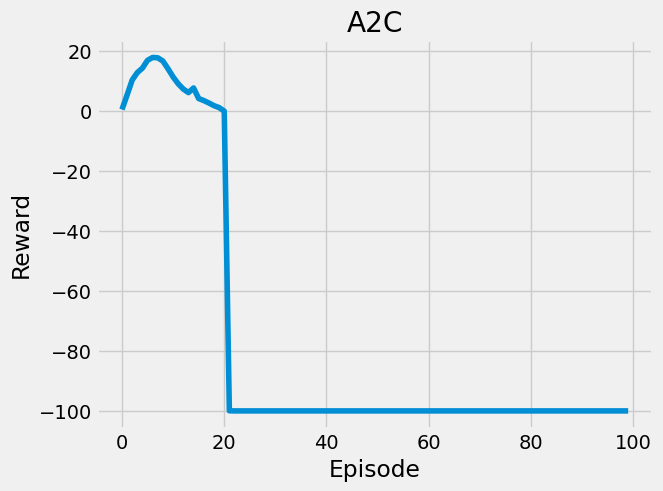

In [13]:
# Вычисление скользящего среднего
total_reward = [s.cpu().detach().numpy().mean() for s in stats['expected_reward']]
window_size = 100
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')

plt.plot(total_reward)
plt.plot(moving_avg)
plt.title('A2C')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

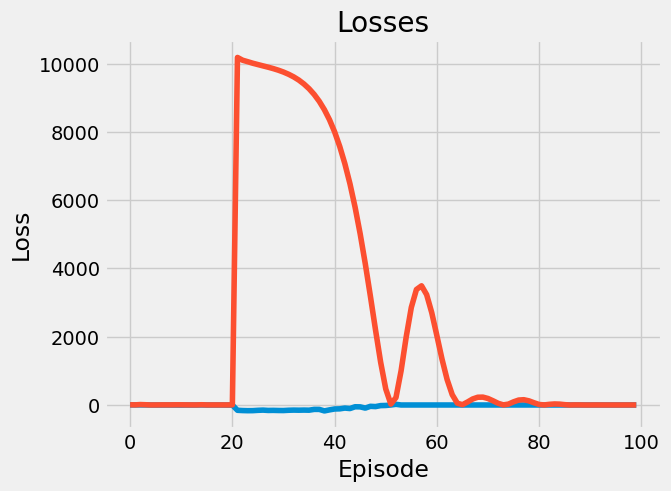

In [14]:
plt.plot(stats['policy_loss'])
plt.plot(stats['value_loss'])
plt.title('Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()

# Replay

In [15]:
def record_video(env, agent, out_directory, fps=30):
    images = []
    done = False
    state, _ = env.reset()
    
    img = env.render()
    images.append(img)
    
    i = 0
    while not done:
        i += 1
        state = torch.Tensor(np.array(state)).to(device)
        
        with torch.no_grad():
            dist, _ = agent(state) 
        action = dist.sample()
        
        state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        img = env.render()
        images.append(img)
        
        if i > 2000:
            break
    imageio.mimsave('./result/test.gif',
                    [np.array(img) for _, img in enumerate(images)],
                    fps=fps)

In [16]:
os.makedirs('./result/', exist_ok=True)
env_name = "CarRacing-v2"

def wrapped_env(env_name):
    env = gym.make(
        env_name,
        render_mode='rgb_array',
        continuous=False
    )
    env = MaxAndSkipEnv(env, skip=4)
    env = ResizeObservation(env, 84)
    env = GrayScaleObservation(env)
    env = FrameStack(env, 5)
    return env
env = wrapped_env(env_name)
record_video(env, agent, out_directory=None)